In [ ]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Kalman Filter 1D example

In [8]:

class KalmanFilter:
    """
    Implements a basic Kalman Filter for linear state estimation.

    Attributes
    ----------
    F : NDArray[np.float64]
        State transition matrix (system dynamics).
    H : NDArray[np.float64]
        Observation matrix (maps state to measurements).
    B : NDArray[np.float64]
        Control matrix (optional).
    Q : NDArray[np.float64]
        Process noise covariance matrix.
    R : NDArray[np.float64]
        Measurement noise covariance matrix.
    P : NDArray[np.float64]
        Estimate error covariance matrix.
    x : NDArray[np.float64]
        Current estimated state vector.
    state_dim : int
        Dimension of the state vector.
    measure_dim : int
        Dimension of the observation vector.
    """

    def __init__(
        self,
        transition_matrix: NDArray[np.float64],
        observation_matrix: NDArray[np.float64],
        control_matrix: NDArray[np.float64] | None = None,
        process_noise_cov: NDArray[np.float64] | None = None,
        measurement_noise_cov: NDArray[np.float64] | None = None,
        estimate_cov: NDArray[np.float64] | None = None,
        initial_state: NDArray[np.float64] | None = None,
    ):
        """
        Initialize the Kalman Filter.

        Parameters
        ----------
        transition_matrix : NDArray[np.float64]
            The state transition matrix (F).
        observation_matrix : NDArray[np.float64]
            The observation matrix (H).
        control_matrix : NDArray[np.float64], optional
            The control input matrix (B). Default is zero matrix.
        process_noise_cov : NDArray[np.float64], optional
            The process noise covariance matrix (Q). Default is identity.
        measurement_noise_cov : NDArray[np.float64], optional
            The measurement noise covariance matrix (R). Default is identity.
        estimate_cov : NDArray[np.float64], optional
            Initial estimate covariance matrix (P). Default is identity.
        initial_state : NDArray[np.float64], optional
            Initial state estimate vector (x0). Default is zero vector.
        """
        if transition_matrix is None or observation_matrix is None:
            raise ValueError("System dynamics must be defined with transition and observation matrices.")

        self.state_dim = transition_matrix.shape[1]
        self.measure_dim = observation_matrix.shape[0]

        self.F = transition_matrix
        self.H = observation_matrix
        self.B = np.zeros((self.state_dim, 1)) if control_matrix is None else control_matrix
        self.Q = np.eye(self.state_dim) if process_noise_cov is None else process_noise_cov
        self.R = np.eye(self.measure_dim) if measurement_noise_cov is None else measurement_noise_cov
        self.P = np.eye(self.state_dim) if estimate_cov is None else estimate_cov
        self.x = np.zeros((self.state_dim, 1)) if initial_state is None else initial_state

    def predict(self, control_input: NDArray[np.float64] | float = 0) -> NDArray[np.float64]:
        """
        Predict the next state and update the estimate covariance.

        Parameters
        ----------
        control_input : float or NDArray[np.float64], optional
            External control input. Default is 0.

        Returns
        -------
        NDArray[np.float64]
            Predicted state vector.
        """
        u = np.array([[control_input]]) if np.isscalar(control_input) else control_input
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, measurement: float | NDArray[np.float64]) -> None:
        """
        Update the Kalman Filter from a new measurement.

        Parameters
        ----------
        measurement : float or NDArray[np.float64]
            Observation at the current time step.
        """
        z = np.array([[measurement]]) if np.isscalar(measurement) else measurement.reshape(-1, 1)
        y = z - self.H @ self.x  # Measurement residual
        S = self.R + self.H @ self.P @ self.H.T  # Residual covariance
        K = self.P @ self.H.T @ np.linalg.inv(S)  # Kalman Gain

        self.x = self.x + K @ y
        I = np.eye(self.state_dim)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + K @ self.R @ K.T

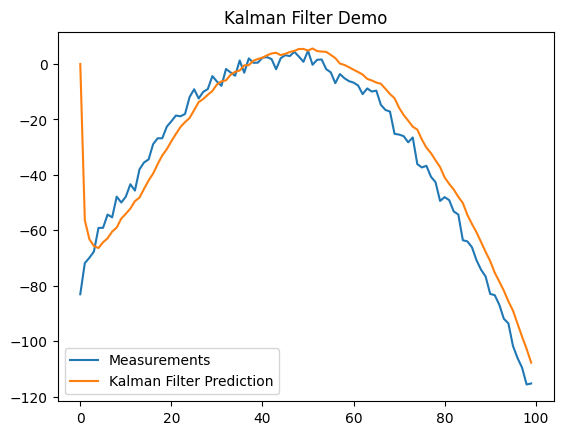

In [24]:
dt = 1.0 / 60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([[1, 0, 0]])
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([[0.5]])

x_vals = np.linspace(-10, 10, 100)
noisy_measurements = -(x_vals**2 + 2 * x_vals - 2) + np.random.normal(0, 2, 100)

kf = KalmanFilter(transition_matrix=F, observation_matrix=H, process_noise_cov=Q, measurement_noise_cov=R)
predictions = []

for z in noisy_measurements:
    prediction = H @ kf.predict()
    predictions.append(prediction.item())
    kf.update(z)

plt.plot(noisy_measurements, label='Measurements')
plt.plot(predictions, label='Kalman Filter Prediction')
plt.legend()
plt.title("Kalman Filter Demo")
plt.show()    